<a href="https://colab.research.google.com/github/buwituze/emergency-companion-chatbot/blob/main/Emergency_companion_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emergency Companion

Domain: Healthcare (Emergency Response)

Purpose: Assists users with emergency first aid guidance and preparedness information

In [ ]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
import warnings
import torch

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

## Load and Format Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/Emergency-companion-chatbot/Dataset/intents.json"

with open(dataset_path, "r") as f:
    data = json.load(f)

rows = []
for intent in data["intents"]:
    tag = intent["tag"]
    responses = intent["responses"]

    if not responses or all(r.strip() == "" for r in responses):
        print(f"Skipping intent '{tag}' - no valid responses")
        continue

    valid_responses = [r for r in responses if r.strip() != ""]

    for pattern in intent["patterns"]:
        for response in valid_responses:
            rows.append({
                "tag": tag,
                "pattern": pattern.strip(),
                "response": response.strip()
            })

df = pd.DataFrame(rows)

print("Dataset loaded successfully")
print(f"Total samples: {len(df)}")
print(f"Unique intents: {df['tag'].nunique()}")
print(f"Intents with data: {df['tag'].unique().tolist()}")

Skipping intent 'Frost bite' - no valid responses
Skipping intent 'Heat Exhaustion' - no valid responses
Skipping intent 'Heat Stroke' - no valid responses
Skipping intent 'Insect Bites' - no valid responses
Skipping intent 'nose bleed' - no valid responses
Skipping intent 'Pulled Muscle' - no valid responses
Skipping intent 'Rectal bleeding' - no valid responses
Skipping intent 'Sun Burn' - no valid responses
Skipping intent 'Testicle Pain' - no valid responses
Skipping intent 'Vertigo' - no valid responses
Skipping intent 'Normal Bleeding' - no valid responses
Skipping intent 'Eye Injury' - no valid responses
Skipping intent 'Chemical Burn' - no valid responses
Skipping intent 'Poison' - no valid responses
Skipping intent 'Teeth' - no valid responses
Skipping intent 'seizure' - no valid responses
Skipping intent 'Head Injury' - no valid responses
Skipping intent 'Fainting' - no valid responses
Dataset loaded successfully
Total samples: 139
Unique intents: 28
Intents with data: ['Cuts

Data Exploration

In [ ]:
print("\nFirst 10 rows:")
print(df.head(10))

print(f"\nDataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nNull values:\n{df.isnull().sum()}")
print(f"\nDuplicate patterns: {df.duplicated(subset=['pattern']).sum()}")

print("\n\nIntent Distribution:")
print(df['tag'].value_counts())

empty_responses = df[df['response'].str.strip() == '']
print(f"\nEmpty responses found: {len(empty_responses)}")


First 10 rows:
        tag                            pattern  \
0      Cuts                What to do if Cuts?   
1      Cuts                  How to cure Cuts?   
2      Cuts  Which medicine to apply for Cuts?   
3      Cuts             what to apply on cuts?   
4      Cuts                               Cuts   
5  greeting                                 Hi   
6  greeting                        How are you   
7  greeting                   Is anyone there?   
8  greeting                              Hello   
9  greeting                           Whats up   

                                            response  
0  Wash the cut properly to prevent infection and...  
1  Wash the cut properly to prevent infection and...  
2  Wash the cut properly to prevent infection and...  
3  Wash the cut properly to prevent infection and...  
4  Wash the cut properly to prevent infection and...  
5                 Hi , i am your paramedic assistant  
6                 Hi , i am your paramedic assis

### Visualizing Unproccessed Data

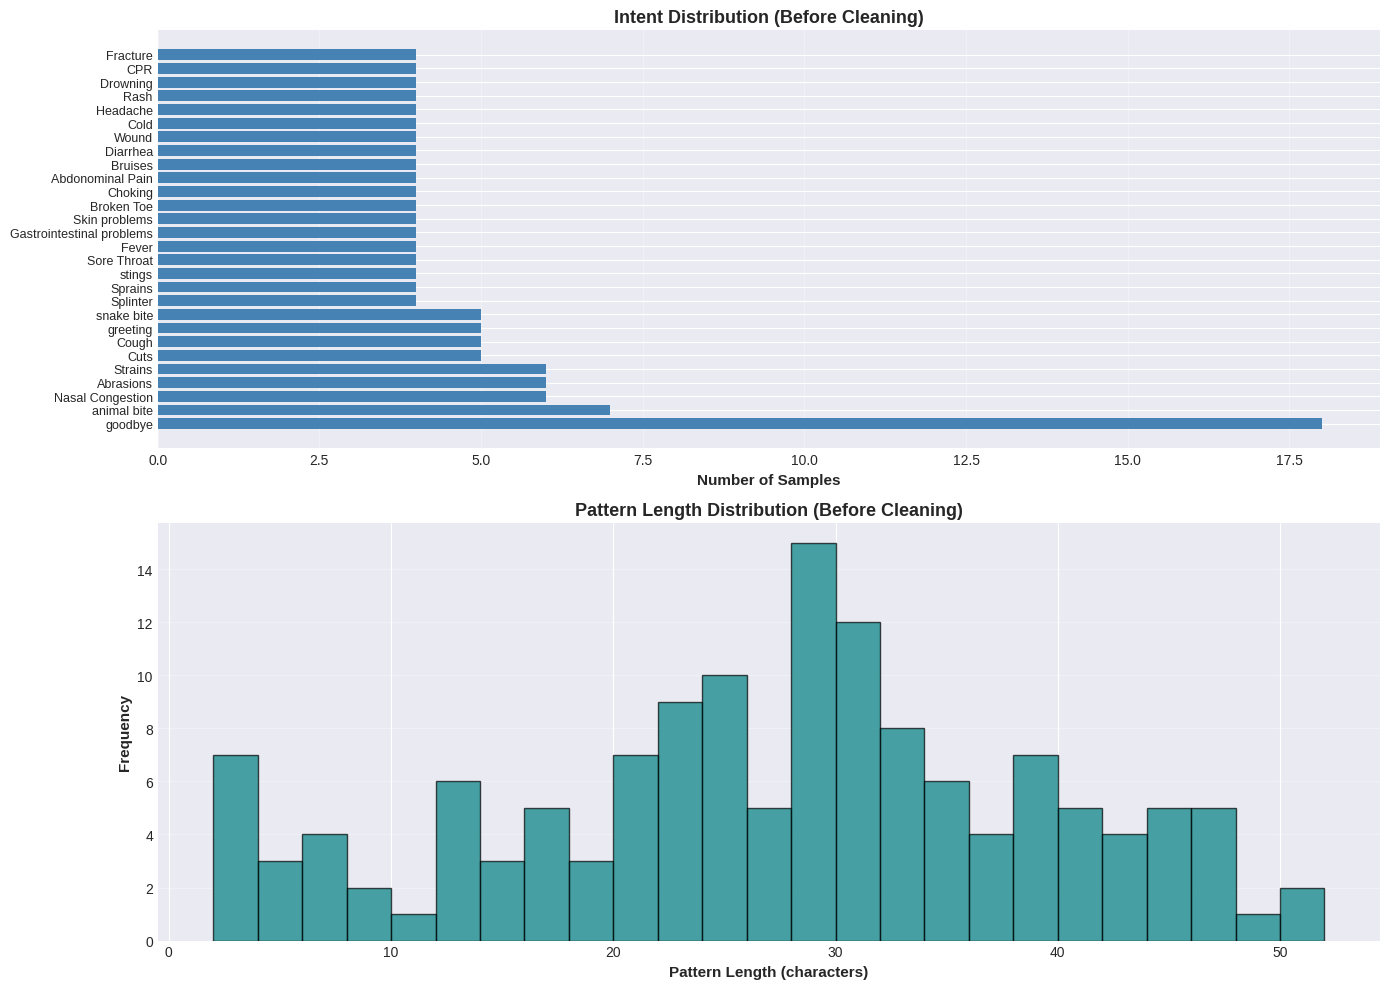

Visualized dataset


In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

# Intent distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

intent_counts = df['tag'].value_counts()
axes[0].barh(range(len(intent_counts)), intent_counts.values, color='steelblue')
axes[0].set_yticks(range(len(intent_counts)))
axes[0].set_yticklabels(intent_counts.index, fontsize=9)
axes[0].set_xlabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0].set_title('Intent Distribution (Before Cleaning)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Pattern length distribution
df["pattern_length"] = df["pattern"].apply(len)
axes[1].hist(df["pattern_length"], bins=25, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Pattern Length (characters)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Pattern Length Distribution (Before Cleaning)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualized dataset")

## Data Processing

In [ ]:
def clean_text(text):
    text = str(text).strip()
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'[^\w\s\.\,\?\!\-\:\(\)]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

initial_size = len(df)

df["pattern"] = df["pattern"].apply(clean_text)
df["response"] = df["response"].apply(clean_text)

df = df[(df['pattern'].str.strip() != '') & (df['response'].str.strip() != '')]

df.drop_duplicates(subset=["pattern", "response"], inplace=True)

df.dropna(inplace=True)

df = df[df['response'].str.len() > 20]

df.reset_index(drop=True, inplace=True)

print(f"Samples before cleaning: {initial_size}")
print(f"Samples after cleaning: {len(df)}")
print(f"Samples removed: {initial_size - len(df)}")
print(f"\nFinal dataset statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Unique patterns: {df['pattern'].nunique()}")
print(f"  Unique responses: {df['response'].nunique()}")
print(f"  Active intents: {df['tag'].nunique()}")

Samples before cleaning: 139
Samples after cleaning: 121
Samples removed: 18

Final dataset statistics:
  Total samples: 121
  Unique patterns: 121
  Unique responses: 27
  Active intents: 27


#### Visualizing Proccessed Data

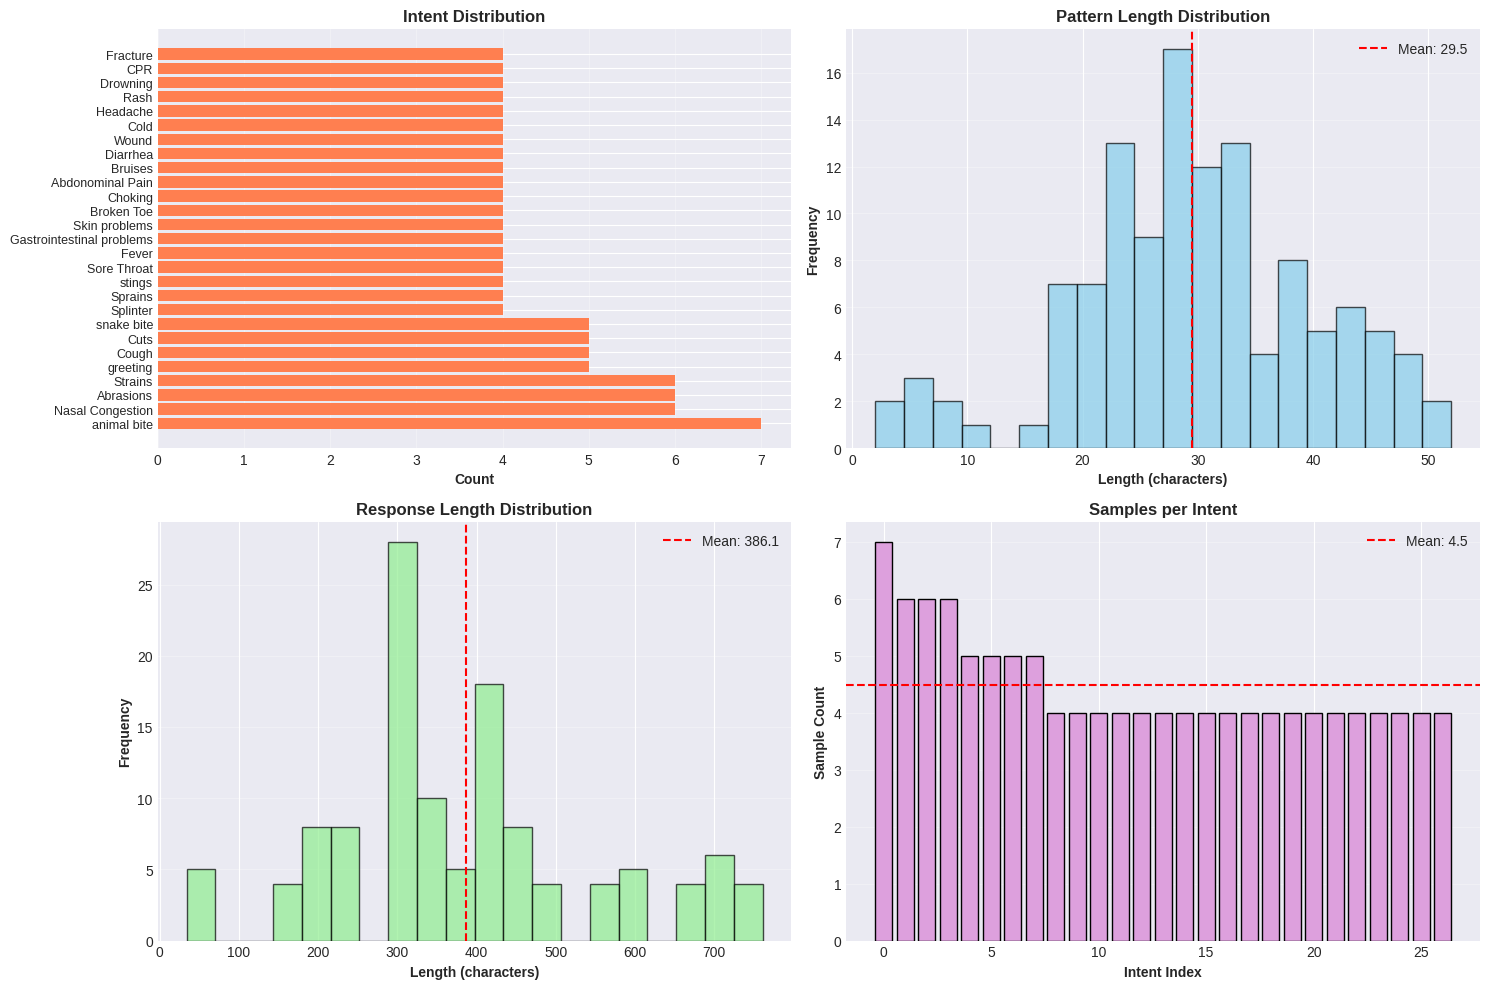


Dataset Statistics:
  Average pattern length: 29.49 chars
  Average response length: 386.11 chars
  Min samples per intent: 4
  Max samples per intent: 7


In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Intent distribution
intent_counts = df['tag'].value_counts()
axes[0, 0].barh(range(len(intent_counts)), intent_counts.values, color='coral')
axes[0, 0].set_yticks(range(len(intent_counts)))
axes[0, 0].set_yticklabels(intent_counts.index, fontsize=9)
axes[0, 0].set_xlabel('Count', fontsize=10, fontweight='bold')
axes[0, 0].set_title('Intent Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Pattern lengths
df["pattern_length"] = df["pattern"].apply(len)
axes[0, 1].hist(df["pattern_length"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Length (characters)', fontsize=10, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Pattern Length Distribution', fontsize=12, fontweight='bold')
axes[0, 1].axvline(df["pattern_length"].mean(), color='red', linestyle='--', label=f'Mean: {df["pattern_length"].mean():.1f}')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Response lengths
df["response_length"] = df["response"].apply(len)
axes[1, 0].hist(df["response_length"], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Length (characters)', fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=10, fontweight='bold')
axes[1, 0].set_title('Response Length Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(df["response_length"].mean(), color='red', linestyle='--', label=f'Mean: {df["response_length"].mean():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Samples per intent
axes[1, 1].bar(range(len(intent_counts)), intent_counts.values, color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Intent Index', fontsize=10, fontweight='bold')
axes[1, 1].set_ylabel('Sample Count', fontsize=10, fontweight='bold')
axes[1, 1].set_title('Samples per Intent', fontsize=12, fontweight='bold')
axes[1, 1].axhline(intent_counts.mean(), color='red', linestyle='--', label=f'Mean: {intent_counts.mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDataset Statistics:")
print(f"  Average pattern length: {df['pattern_length'].mean():.2f} chars")
print(f"  Average response length: {df['response_length'].mean():.2f} chars")
print(f"  Min samples per intent: {intent_counts.min()}")
print(f"  Max samples per intent: {intent_counts.max()}")

### Data Augmentation

In [ ]:
def augment_data(df, min_samples_per_intent=3):
    augmented_rows = []

    for tag in df['tag'].unique():
        tag_data = df[df['tag'] == tag]
        current_count = len(tag_data)

        if current_count < min_samples_per_intent:
            needed = min_samples_per_intent - current_count
            samples_to_add = tag_data.sample(n=min(needed, current_count), replace=True, random_state=42)
            augmented_rows.append(samples_to_add)

    if augmented_rows:
        augmented_df = pd.concat([df] + augmented_rows, ignore_index=True)
        print(f"Added {len(augmented_df) - len(df)} augmented samples")
        return augmented_df

    return df

df = augment_data(df, min_samples_per_intent=3)
print(f"Total samples after augmentation: {len(df)}")

Total samples after augmentation: 121


### Tokeneization

In [ ]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name, legacy=False)
model = T5ForConditionalGeneration.from_pretrained(model_name)

print(f"Model: {model_name}")
print(f"Vocabulary size: {len(tokenizer)}")
print(f"Model parameters: {model.num_parameters():,}")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Model moved to: {device}")

Model: t5-small
Vocabulary size: 32100
Model parameters: 60,506,624
Model moved to: cuda


In [ ]:
MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 256

def preprocess_function(examples):
    inputs = ["answer this emergency question: " + q for q in examples["pattern"]]

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors=None
    )

    labels = tokenizer(
        examples["response"],
        max_length=MAX_TARGET_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors=None
    )

    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

print("Tokenization function defined")
print(f"Max input length: {MAX_INPUT_LENGTH}")
print(f"Max target length: {MAX_TARGET_LENGTH}")

Tokenization function defined
Max input length: 128
Max target length: 256


### Spiliting Data

In [ ]:
print(f"Total samples before split: {len(df)}")
print(f"Unique tags: {df['tag'].nunique()}")

try:
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df['tag']
    )
    print("Using stratified split")
except ValueError:
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42
    )
    print("Using random split (stratification not possible)")

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print(f"Train/Test ratio: {len(train_df)/len(test_df):.2f}")

print("\nTraining set distribution:")
print(train_df['tag'].value_counts())
print("\nTesting set distribution:")
print(test_df['tag'].value_counts())

Total samples before split: 121
Unique tags: 27
Using random split (stratification not possible)

Training samples: 96
Testing samples: 25
Train/Test ratio: 3.84

Training set distribution:
tag
snake bite                   5
Strains                      5
greeting                     5
animal bite                  5
CPR                          4
Splinter                     4
Rash                         4
Headache                     4
Sore Throat                  4
Wound                        4
Abrasions                    4
Diarrhea                     4
Skin problems                4
Nasal Congestion             4
Fracture                     3
Choking                      3
Drowning                     3
Gastrointestinal problems    3
Sprains                      3
Cuts                         3
Fever                        3
Broken Toe                   3
Bruises                      3
stings                       3
Cold                         2
Cough                        2


### Create and Tokenize Dataset

In [ ]:
train_dataset = Dataset.from_pandas(
    train_df[['pattern', 'response']].reset_index(drop=True)
)
test_dataset = Dataset.from_pandas(
    test_df[['pattern', 'response']].reset_index(drop=True)
)

print("Converting to HuggingFace datasets...")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

print("\nTokenizing training data...")
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['pattern', 'response'],
    desc="Tokenizing train data"
)

print("Tokenizing test data...")
test_dataset = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['pattern', 'response'],
    desc="Tokenizing test data"
)

print("\nCompleted tokenization")
print(f"Train dataset features: {train_dataset.column_names}")
print(f"Test dataset features: {test_dataset.column_names}")

print("\nSample tokenized input:")
sample = train_dataset[0]
print(f"Input IDs shape: {len(sample['input_ids'])}")
print(f"Labels shape: {len(sample['labels'])}")

Converting to HuggingFace datasets...
Train dataset size: 96
Test dataset size: 25

Tokenizing training data...


Tokenizing train data:   0%|          | 0/96 [00:00<?, ? examples/s]

Tokenizing test data...


Tokenizing test data:   0%|          | 0/25 [00:00<?, ? examples/s]


Completed tokenization
Train dataset features: ['input_ids', 'attention_mask', 'labels']
Test dataset features: ['input_ids', 'attention_mask', 'labels']

Sample tokenized input:
Input IDs shape: 128
Labels shape: 256


## Model Training

In [ ]:
from transformers import EarlyStoppingCallback

# setting training configs
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

training_args = TrainingArguments(
    output_dir="./emergency_model_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    warmup_steps=50,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    report_to="none",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
    seed=42,
    dataloader_num_workers=2,
    disable_tqdm=False
)

print("Training Configuration:")
print(f"  Max Epochs: {training_args.num_train_epochs}")
print(f"  Early Stopping: Enabled (patience=3)")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")

Training Configuration:
  Max Epochs: 20
  Early Stopping: Enabled (patience=3)
  Learning rate: 5e-05
  Batch size: 8


In [ ]:
# model training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Trainer initialized with early stopping")
print("Starting training...\n")

try:
    train_result = trainer.train()
    print("Completed training")
    print("-"*70)
    print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
except Exception as e:
    print(f"\nTraining error: {e}")

Trainer initialized with early stopping
Starting training...



Epoch,Training Loss,Validation Loss
1,No log,6.492093
2,6.287300,6.360776
3,6.287300,5.977980
4,6.448600,5.312762
5,5.542900,4.562645
6,5.542900,4.188976
7,4.798800,3.973392
8,4.798800,3.820221
9,4.348300,3.700034
10,4.076900,3.601363


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Completed training
----------------------------------------------------------------------
Final training loss: 4.4650


## Model Evaluation

In [ ]:
try:
    import evaluate
    print("evaluate library loaded")
except ImportError:
    print("Installing evaluate library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "evaluate"])
    import evaluate
    print("evaluate library installed")

bleu_metric = evaluate.load("bleu")

def compute_bleu(eval_df, num_samples=None):
    if num_samples:
        eval_df = eval_df.sample(n=min(num_samples, len(eval_df)), random_state=42)

    predictions = []
    references = []

    print(f"Evaluating {len(eval_df)} samples...")

    model.eval()
    with torch.no_grad():
        for idx in range(len(eval_df)):
            pattern = eval_df.iloc[idx]["pattern"]
            reference = eval_df.iloc[idx]["response"]

            input_text = "answer this emergency question: " + pattern
            input_ids = tokenizer(
                input_text,
                return_tensors="pt",
                max_length=MAX_INPUT_LENGTH,
                truncation=True
            ).input_ids.to(device)

            outputs = model.generate(
                input_ids,
                max_length=MAX_TARGET_LENGTH,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3,
                temperature=0.7
            )

            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

            predictions.append(prediction)
            references.append([reference])

            if (idx + 1) % 10 == 0:
                print(f"  Processed {idx + 1}/{len(eval_df)}")

    result = bleu_metric.compute(predictions=predictions, references=references)

    return result["bleu"], predictions, references

test_bleu, test_preds, test_refs = compute_bleu(test_df)
print(f"\nTest BLEU Score: {test_bleu:.4f}")

train_bleu, _, _ = compute_bleu(train_df, num_samples=30)
print(f"Train BLEU Score (sample): {train_bleu:.4f}")

print("SAMPLE PREDICTIONS")
print("-" * 70)

for i in range(min(5, len(test_preds))):
    print(f"\n[Example {i+1}]")
    print(f"Pattern: {test_df.iloc[i]['pattern']}")
    print(f"Expected: {test_refs[i][0][:100]}...")
    print(f"Predicted: {test_preds[i][:100]}...")

evaluate library loaded


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating 25 samples...
  Processed 10/25
  Processed 20/25

Test BLEU Score: 0.0000
Evaluating 30 samples...
  Processed 10/30
  Processed 20/30
  Processed 30/30
Train BLEU Score (sample): 0.0010
SAMPLE PREDICTIONS
----------------------------------------------------------------------

[Example 1]
Pattern: How to cure cough?
Expected: 1) Honey:- Use honey to treat a cough, mix 2 teaspoons (tsp) with warm water or an herbal tea. Drink...
Predicted: Resolve this emergency emergency question: How to cure cough?...

[Example 2]
Pattern: Which medicine to take if I get cough?
Expected: 1) Honey:- Use honey to treat a cough, mix 2 teaspoons (tsp) with warm water or an herbal tea. Drink...
Predicted: Answer this emergency question: Do not take any medications if you have a cough. Do not use any of t...

[Example 3]
Pattern: Cuts
Expected: Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes...
Predicted: Raise à cette question d'urgence....



In [ ]:
import pandas as pd

eval_results = trainer.evaluate()

metrics_data = {
    'Category': ['Hyperparameters', 'Hyperparameters', 'Hyperparameters', 'Hyperparameters',
                 'Hyperparameters', 'Performance', 'Performance', 'Performance', 'Performance',
                 'Data', 'Data', 'Data'],
    'Metric': ['Learning Rate', 'Batch Size', 'Epochs', 'Max Input Length', 'Max Target Length',
               'Training Loss', 'Validation Loss', 'Test BLEU Score', 'Train BLEU Score',
               'Training Samples', 'Test Samples', 'Unique Intents'],
    'Value': [training_args.learning_rate,
              training_args.per_device_train_batch_size,
              training_args.num_train_epochs,
              MAX_INPUT_LENGTH,
              MAX_TARGET_LENGTH,
              f"{train_result.metrics['train_loss']:.4f}",
              f"{eval_results['eval_loss']:.4f}",
              f"{test_bleu:.4f}",
              f"{train_bleu:.4f}",
              len(train_df),
              len(test_df),
              df['tag'].nunique()]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nPerformance Summary")
print("="*70)
print(metrics_df.to_string(index=False))

print("\n")
drive_model_path = "/content/drive/MyDrive/Emergency-companion-chatbot/Model/emergency-companion-model"
model.save_pretrained(drive_model_path)
tokenizer.save_pretrained(drive_model_path)
print(f"Model saved to Google Drive: {drive_model_path}")

model.save_pretrained("./emergency-companion-model")
tokenizer.save_pretrained("./emergency-companion-model")



Performance Summary
       Category            Metric    Value
Hyperparameters     Learning Rate  0.00005
Hyperparameters        Batch Size        8
Hyperparameters            Epochs       20
Hyperparameters  Max Input Length      128
Hyperparameters Max Target Length      256
    Performance     Training Loss   4.4650
    Performance   Validation Loss   3.2112
    Performance   Test BLEU Score   0.0000
    Performance  Train BLEU Score   0.0010
           Data  Training Samples       96
           Data      Test Samples       25
           Data    Unique Intents       27


Model saved to Google Drive: /content/drive/MyDrive/Emergency-companion-chatbot/Model/emergency-companion-model


('./emergency-companion-model/tokenizer_config.json',
 './emergency-companion-model/special_tokens_map.json',
 './emergency-companion-model/spiece.model',
 './emergency-companion-model/added_tokens.json')

## Inference Func

In [ ]:
def predict_response(user_query, max_length=MAX_TARGET_LENGTH, temperature=0.7):
    model.eval()

    input_text = "answer this emergency question: " + user_query.strip()
    input_ids = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    ).input_ids.to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=max_length,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=3,
            temperature=temperature,
            do_sample=False,
            top_k=50,
            top_p=0.95
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

print("\n Chatbot has positive performance")


 Chatbot has positive performance


## Model Testing

In [ ]:
test_queries = [
    "How do I treat a cut?",
    "What to do if someone is choking?",
    "How to handle a snake bite?",
    "What should I do for a fever?",
    "Hello",
    "How to treat a sprain?",
    "What to do for a cough?",
    "How do I treat a broken toe?",
    "Help with diarrhea",
    "Goodbye"
]

for query in test_queries:
    response = predict_response(query)
    print(f"User: {query}")
    print(f"Companion: {response}\n")
    print("-" * 70 + "\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


User: How do I treat a cut?
Companion: Answer this emergency question: How do I treat a cut?

----------------------------------------------------------------------

User: What to do if someone is choking?
Companion: Answer this emergency emergency question: What should be done if someone is choking?

----------------------------------------------------------------------

User: How to handle a snake bite?
Companion: Answer this emergency question: How to handle a snake bite?

----------------------------------------------------------------------

User: What should I do for a fever?
Companion: Answer this emergency question: What should I do for a fever?

----------------------------------------------------------------------

User: Hello
Companion: Raise à cette question d'urgence. Vous pouvez remplacer l'urgence par une urgence.

----------------------------------------------------------------------

User: How to treat a sprain?
Companion: How to treat a sprain?

----------------------